In [1]:
"""
Plotting a sounding with indices and a hodograph
================================================
"""

import warnings # Silence the warnings from SHARPpy
warnings.filterwarnings("ignore")
import sharppy.plot.skew as skew
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.collections import LineCollection
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from matplotlib import gridspec
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder

In [28]:
def decode(filename, skip=30):

    dec = SPCDecoder(filename)

    if dec is None:
        raise IOError("Could not figure out the format of '%s'!" % filename)

    # Returns the set of profiles from the file that are from the "Profile" class.
    profs = dec.getProfiles()
    stn_id = dec.getStnId()

    for k in list(profs._profs.keys()):
        all_prof = profs._profs[k]
        dates = profs._dates
        for i in range(len(all_prof)):
            prof = all_prof[i]
            new_prof = profile.create_profile(pres=prof.pres[::skip], hght=prof.hght[::skip], tmpc=prof.tmpc[::skip], dwpc=prof.dwpc[::skip], 
                                              wspd=prof.wspd[::skip], wdir=prof.wdir[::skip], strictQC=False, profile='convective', date=dates[i])
            return new_prof, dates[i], stn_id 

##############
   INDICES    
##############
0-1 km SRH: 3 m2/s2
0-1 km Shear: 2 kts
0-3 km SRH: 43 m2/s2
0-6 km Shear: 17 kts
EBWD: 18 kts
Eff. SRH: 50 m2/s2
K-index: 22 
MLCAPE: 2397 J/kg
MLCIN: -113 J/kg
MLEL: 21418 m AGL
MLLCL: 3094 m AGL
MLLFC: 4043 m AGL
MLLI: -4 C
MUCAPE: 3603 J/kg
MUCIN: -41 J/kg
MUEL: 21697 m AGL
MULCL: 2937 m AGL
MULFC: 3541 m AGL
MULI: -6 C
PWV: 1.04 inch
SBCAPE: 3603 J/kg
SBCIN: -41 J/kg
SBEL: 21697 m AGL
SBLCL: 2937 m AGL
SBLFC: 3541 m AGL
SBLI: -6 C
SCP: 3.3 
SHIP: 0.3 
STP(cin): 0.0 
STP(fix): 0.0 

#############
 SARS OUTPUT 
#############
Supercell
-----------
NO QUALITY MATCHES
Total Loose Matches: 0
# of Loose Matches that met Criteria: 0
SVR Probability: 0.0

Hail
-----------
NO QUALITY MATCHES
Total Loose Matches: 0.0
# of Loose Matches that met Criteria: 0.0
SVR Probability: 0

('SHARPpy Skew-T image output at:', '20200119_0259_OAX.png')


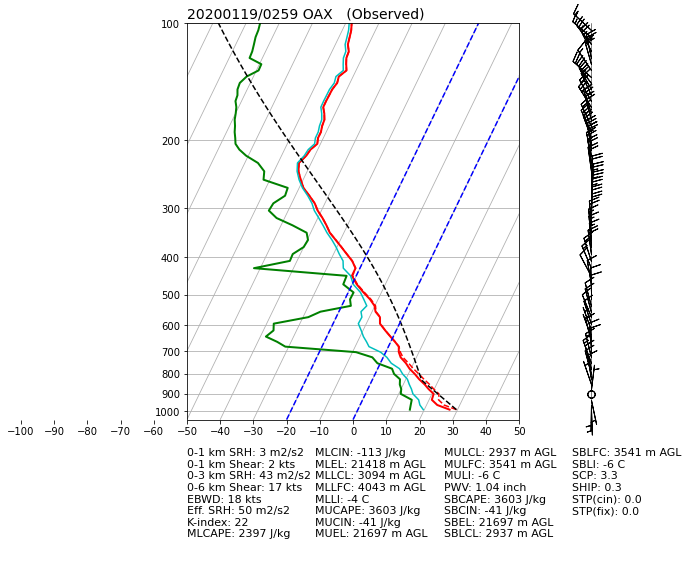

In [29]:
FILENAME = '/home/meso/Insync/onedrive/sync/projects/Hail/case_studies/20200119-melb/sounding/86282_20200119_0259.oax'

prof, time, location = decode(FILENAME)
# Bounds of the pressure axis 
pb_plot=1050
pt_plot=100
dp_plot=10
plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)
# Open up the text file with the data in columns (e.g. the sample OAX file distributed with SHARPpy)
title = time.strftime('%Y%m%d/%H%M') + ' ' + location + '   (Observed)'

# Set up the figure in matplotlib.
fig = plt.figure(figsize=(12, 8), facecolor='w')
gs = gridspec.GridSpec(4,4, width_ratios=[1,5,1,1])
ax = plt.subplot(gs[0:3, 0:2], projection='skewx')
skew.draw_title(ax, title)
ax.grid(True)
plt.grid(True)

# Plot the background variables
presvals = np.arange(1000, 0, -10)

ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)
ax.semilogy(prof.vtmp[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'r--')
ax.semilogy(prof.wetbulb[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'c-')

# Plot the parcel trace, but this may fail.  If it does so, inform the user.
try:
    ax.semilogy(prof.mupcl.ttrace, prof.mupcl.ptrace, 'k--')
except:
    print("Couldn't plot parcel traces...")

# Highlight the 0 C and -20 C isotherms.
l = ax.axvline(0, color='b', ls='--')
l = ax.axvline(-20, color='b', ls='--')

# Disables the log-formatting that comes with semilogy
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-50,30)

# Plot the hodograph data.
# inset_axes = skew.draw_hodo_inset(ax, prof)
# inset_axes.set_ylim(-20,20)
# inset_axes.set_xlim(-20,20)
# skew.plotHodo(inset_axes, prof.hght, prof.u, prof.v, color='r')
#inset_axes.text(srwind[0], srwind[1], 'RM', color='r', fontsize=8)
#inset_axes.text(srwind[2], srwind[3], 'LM', color='b', fontsize=8)

# Draw the wind barbs axis and everything that comes with it.
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.set_xlim(-50,50)
ax2 = plt.subplot(gs[0:3,2])
ax3 = plt.subplot(gs[3,0:3])
skew.plot_wind_axes(ax2)
skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
srwind = params.bunkers_storm_motion(prof)
gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)

ax2.set_xticks(())
ax3.set_xticks(())

# Calculate indices to be shown.  More indices can be calculated here using the tutorial and reading the params module.
p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
sfc = prof.pres[prof.sfc]
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])
scp = params.scp(prof.mupcl.bplus, prof.right_esrh[0], prof.ebwspd)
stp_cin = params.stp_cin(prof.mlpcl.bplus, prof.right_esrh[0], prof.ebwspd, prof.mlpcl.lclhght, prof.mlpcl.bminus)
stp_fixed = params.stp_fixed(prof.sfcpcl.bplus, prof.sfcpcl.lclhght, srh1km[0], utils.comp2vec(prof.sfc_6km_shear[0], prof.sfc_6km_shear[1])[1])
ship = params.ship(prof)

# A routine to perform the correct formatting when writing the indices out to the figure.
def fmt(value, fmt='int'):
    if fmt == 'int':
        try:
            val = int(value)
        except:
            val = str("M")
    else:
        try:
            val = round(value,1)
        except:
            val = "M"
    return val

# Setting a dictionary that is a collection of all of the indices we'll be showing on the figure.
# the dictionary includes the index name, the actual value, and the units.
indices = {'SBCAPE': [fmt(prof.sfcpcl.bplus), 'J/kg'],\
           'SBCIN': [fmt(prof.sfcpcl.bminus), 'J/kg'],\
           'SBLCL': [fmt(prof.sfcpcl.lclhght), 'm AGL'],\
           'SBLFC': [fmt(prof.sfcpcl.lfchght), 'm AGL'],\
           'SBEL': [fmt(prof.sfcpcl.elhght), 'm AGL'],\
           'SBLI': [fmt(prof.sfcpcl.li5), 'C'],\
           'MLCAPE': [fmt(prof.mlpcl.bplus), 'J/kg'],\
           'MLCIN': [fmt(prof.mlpcl.bminus), 'J/kg'],\
           'MLLCL': [fmt(prof.mlpcl.lclhght), 'm AGL'],\
           'MLLFC': [fmt(prof.mlpcl.lfchght), 'm AGL'],\
           'MLEL': [fmt(prof.mlpcl.elhght), 'm AGL'],\
           'MLLI': [fmt(prof.mlpcl.li5), 'C'],\
           'MUCAPE': [fmt(prof.mupcl.bplus), 'J/kg'],\
           'MUCIN': [fmt(prof.mupcl.bminus), 'J/kg'],\
           'MULCL': [fmt(prof.mupcl.lclhght), 'm AGL'],\
           'MULFC': [fmt(prof.mupcl.lfchght), 'm AGL'],\
           'MUEL': [fmt(prof.mupcl.elhght), 'm AGL'],\
           'MULI': [fmt(prof.mupcl.li5), 'C'],\
           '0-1 km SRH': [fmt(srh1km[0]), 'm2/s2'],\
           '0-1 km Shear': [fmt(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1]), 'kts'],\
           '0-3 km SRH': [fmt(srh3km[0]), 'm2/s2'],\
           '0-6 km Shear': [fmt(utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]), 'kts'],\
           'Eff. SRH': [fmt(prof.right_esrh[0]), 'm2/s2'],\
           'EBWD': [fmt(prof.ebwspd), 'kts'],\
           'PWV': [round(prof.pwat, 2), 'inch'],\
           'K-index': [fmt(params.k_index(prof)), ''],\
           'STP(fix)': [fmt(stp_fixed, 'flt'), ''],\
           'SHIP': [fmt(ship, 'flt'), ''],\
           'SCP': [fmt(scp, 'flt'), ''],\
           'STP(cin)': [fmt(stp_cin, 'flt'), '']}

# List the indices within the indices dictionary on the side of the plot.
trans = transforms.blended_transform_factory(ax.transAxes,ax.transData)

# Write out all of the indices to the figure.
print("##############")
print("   INDICES    ")
print("##############")
string = ''
keys = np.sort(list(indices.keys()))
x = 0
counter = 0
for key in keys:
    string = string + key + ': ' + str(indices[key][0]) + ' ' + indices[key][1] + '\n'
    print((key + ": " + str(indices[key][0]) + ' ' + indices[key][1]))
    if counter < 7:
        counter += 1
        continue
    else:
        counter = 0
        ax3.text(x, 1, string, verticalalignment='top', transform=ax3.transAxes, fontsize=11)
        string = ''
        x += 0.3
ax3.text(x, 1, string, verticalalignment='top', transform=ax3.transAxes, fontsize=11)
ax3.set_axis_off()

# Show SARS matches (edited for Keith Sherburn)
try:
    supercell_matches = prof.supercell_matches
    hail_matches = prof.matches 
except:
    supercell_matches = prof.right_supercell_matches
    hail_matches = prof.right_matches

print()
print("#############")
print(" SARS OUTPUT ")
print("#############")
for mtype, matches in zip(['Supercell', 'Hail'], [supercell_matches, hail_matches]):
    print(mtype)
    print('-----------')
    if len(matches[0]) == 0:
        print("NO QUALITY MATCHES")
    for i in range(len(matches[0])):
        print(matches[0][i] + ' ' + matches[1][i])
    print("Total Loose Matches:", matches[2])
    print("# of Loose Matches that met Criteria:", matches[3])
    print("SVR Probability:", matches[4])
    print() 

# Finalize the image formatting and alignments, and save the image to the file.
gs.tight_layout(fig)
fn = time.strftime('%Y%m%d_%H%M') + '_' + location + '.png'
fn = fn.replace('/', '')
print(("SHARPpy Skew-T image output at:", fn))
plt.savefig(fn, bbox_inches='tight', dpi=180)